## load libraries

In [8]:
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, h5py, os, re, tqdm, io, glob, csv, argparse, yaml, time, natsort
import numexpr as nexpr
import ipywidgets as widgets
from joblib import Parallel, delayed
from pygnuplot import gnuplot
from IPython.display import Image
plt.rcParams.update({'font.size': 10})
from ipyfilechooser import FileChooser

### Larch library

In [2]:
import larch
from larch import Group
import larch.math as Lmath
from larch.xafs import autobk, xftf, feffit_transform, feffit_dataset, feffit, feffpath, feffrunner, feffit_report,xftr
from larch.fitting import param, param_group
# from larch.io import read_xdi
from larch import Interpreter

# EXAFS analysis

## Read plot XAFS (9809)

In [18]:
# datdir = widgets.Text(
#     value='./2021March_Motokura',
#     placeholder='Write the directory of data files',
#     description='datdir:',
#     disabled=False 
#     )

datdir = FileChooser('./',
                     Layout=widgets.Layout(width='75%')
                    )

widgets.VBox([
            widgets.Label(value="Data Directory, file name"),
            datdir]
)

### Select a data file

In [19]:

files = [x for x in os.listdir(datdir.selected_path) if '.qd' in x]
files = natsort.natsorted(files)[::-1]
f = widgets.Select(
    value='ru008_0.qd',
    options = files,
    description='Files:',
    disabled=False 
)

sample_name = widgets.Text(
                    value='',
                    placeholder='Write the sample name',
                    description='Sample name:',
                    disabled=False,
                    style = {'description_width': 'initial'}
                    )

widgets.VBox([
            widgets.Label(value="Files"),
            f,
            sample_name]
)


Text(0.5, 1.0, 'ru002_0.qd: RuO2')

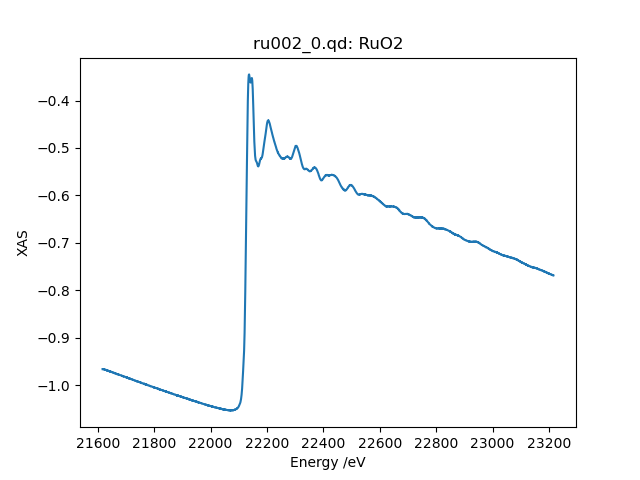

In [23]:

df = pd.read_csv(datdir.selected_path+'/'+f.value,delim_whitespace=True,skiprows=14, names =['Angle_c', 'Angle_o', 'time', 'I0', 'I1'])
E = 12398.52/(2*np.sin(df['Angle_o'].values[np.isfinite(df['Angle_o'].values)]/180*np.pi)*1.63751)
xas = np.log(df['I0'].values/df['I1'].values)[np.isfinite(df['Angle_o'].values)]

plt.figure()
plt.plot(E,xas)
plt.xlabel('Energy /eV')
plt.ylabel('XAS')
plt.title(f.value+': '+sample_name.value)


### Set the conditions for data smoothing

### create widgets

In [21]:
start = widgets.FloatText(
                    value=21620,
                    description='Start E [eV]',
    )
end = widgets.FloatText(
                    value=23200,
                    description='End E [eV]',
    )
points = widgets.FloatText(
                    value=791,
                    description='points',
    )

_kernel = widgets.IntText(
                    value=6,
                    description='kernel size',
    )

E_intp, kernel_size, xas_intp = np.array([]), 1, np.array([])

widgets.VBox([
            widgets.HBox([start,end,points,_kernel]),
             ])

### Plot smoothed data

Text(0.5, 1.0, 'ru002_0.qd: RuO2')

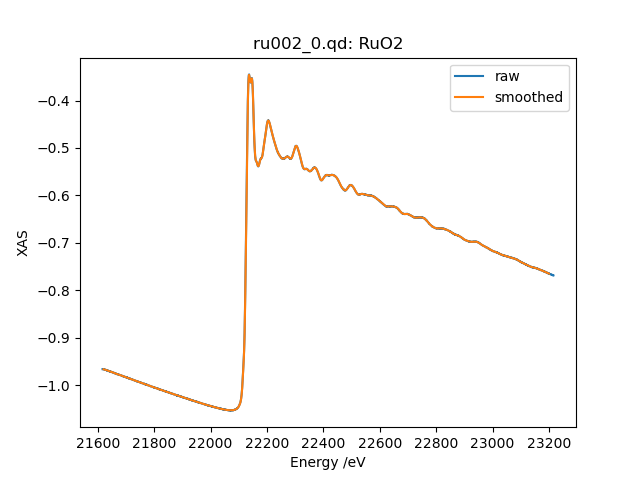

In [24]:
E_intp = np.linspace(start.value,end.value,791)

kernel_size = _kernel.value
kernel = np.ones(kernel_size)/kernel_size

data_convolved = np.convolve(xas, kernel, mode='same')
xas_intp = np.interp(E_intp,E,data_convolved)
plt.figure()
plt.plot(E,xas, label='raw')
plt.plot(E_intp,xas_intp,label='smoothed')
plt.legend()

plt.xlabel('Energy /eV')
plt.ylabel('XAS')
plt.title(f.value+': '+sample_name.value)

## Background subtraction

In [25]:
kstart = widgets.FloatText(
                    value=1.0,
                    description='kmin:',
    )
kend = widgets.FloatText(
                    value=18,
                    description='kmax:',
    )
_rbkg = widgets.FloatText(
                    value=1,
                    description='rbkg:',
    )

clamp_l = widgets.FloatText(
                    value=0.,
                    description='clamp_low:',
    )

clamp_h = widgets.FloatText(
                    value=2.,
                    description='clamp_high:',
    )

kmin_ft = widgets.FloatText(
                    value=3,
                    description='kmin(FT):',
    )
kmax_ft = widgets.FloatText(
                    value=16,
                    description='kmax(FT):',
    )

n_kweight = widgets.BoundedIntText(
                                    value=3,
                                    min=0,
                                    max=3,
                                    step=1,
                                    description='kweight:',
                                    disabled=False
                                )


wintype = widgets.Dropdown(
    value='hanning',
    options=['hanning','parzen','welch','gaussian', 'sine', 'kaiser'],
    description='Win. type:',
    ensure_option=True,
    disabled=False
)

dk_win = widgets.FloatText(
                    value=1,
                    description='dk(window):',
    )
widgets.VBox([widgets.Label(value='======'*6+'==========   autoback parameters   =========='+'======'*6),
            widgets.HBox([kstart,kend,_rbkg]),
            widgets.HBox([clamp_l,clamp_h]),
            widgets.Label(value='======'*6+'==========   fourier conditions   =========='+'======'*6),
            widgets.HBox([kmin_ft,kmax_ft,n_kweight]),
              widgets.HBox([wintype,dk_win]),
            widgets.Label(value='============='*8),
             ])

Text(0.5, 1.0, 'FT')

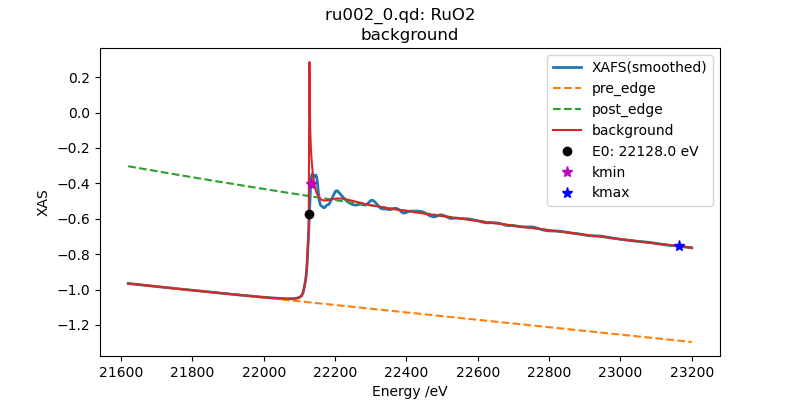

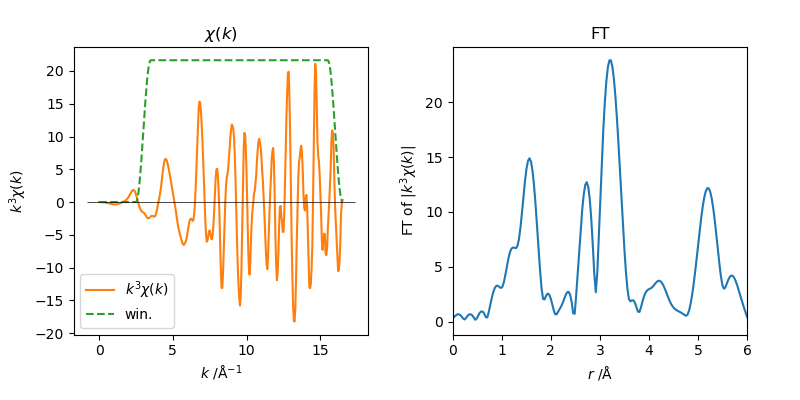

In [31]:
dat = Group()
dat.mu = xas_intp
dat.e = E_intp


#################### autobk  ####################
autobk(dat.e, dat.mu, kmin=kstart.value, kmax=kend.value, rbkg=_rbkg.value,
       clamp_lo = clamp_l.value, clamp_hi = clamp_h.value, group=dat)

fig, ax = plt.subplots()
fig.set_size_inches(8, 4.0)

fig.suptitle(f.value+': '+sample_name.value)
ax.set_title('background')

ax.plot(dat.e,dat.mu,linewidth=2,label='XAFS(smoothed)')

ax.plot(dat.e,dat.pre_edge,'--',label='pre_edge')
ax.plot(dat.e,dat.post_edge,'--',label='post_edge')
ax.plot(dat.e,dat.bkg,'-',label='background')
i_kmin, i_kmax = np.argmin(np.abs(dat.e-(kstart.value**2/0.2626+dat.e0))),\
                np.argmin(np.abs(dat.e-(kend.value**2/0.2626+dat.e0)))
y0,y1 = ax.get_ylim()
_i = np.argmin(np.abs(dat.e-dat.e0))
ax.plot(dat.e0,dat.mu[_i],'o',markersize=6,color='k',label='E0: {:.1f} eV'.format(dat.e0))
ax.plot(dat.e[i_kmin], dat.mu[i_kmin],'*',markersize=8,color='m',label='kmin')
ax.plot(dat.e[i_kmax], dat.mu[i_kmax],'*',markersize=8,color='b',label='kmax')
ax.legend()
# ax.plot(dat.e, dat.mu,label='XAFS(smoothed)')

ax.set_xlabel('Energy /eV')
ax.set_ylabel('XAS')

#################### FT  ####################
xftf(dat.k, dat.chi, kmin=kmin_ft.value, kmax=kmax_ft.value, dk=dk_win.value, 
     window=wintype.value,kweight=n_kweight.value, group=dat)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8, 4.0)
fig.tight_layout(pad=3)
ax[0].plot(dat.k,dat.chi*dat.k**n_kweight.value,color='C1',
           label='$k^{:d}\chi$($k$)'.format(n_kweight.value))

x0, x1 = ax[0].get_xlim()
y0, y1 = ax[0].get_ylim()
scale = (np.abs(y0)+np.abs(y1))/2
ax[0].plot(dat.k,dat.kwin*scale,'--',color='C2',
           label='win.')
ax[0].hlines(0.0,x0,x1,linewidth=0.5,color='k')
ax[0].set_ylabel('$k^{:d}\chi$($k$)'.format(n_kweight.value))
ax[0].set_xlabel('$k\ /\mathrm{\AA^{-1}}$')
ax[0].legend()
ax[0].set_title('$\chi(k)$')

ax[1].plot(dat.r,dat.chir_mag)
ax[1].set_xlim([0.0,6.0])
ax[1].set_xlabel('$r\ /\mathrm{\AA}$')
ax[1].set_ylabel('FT of |$k^{:d}\chi$($k$)|'.format(n_kweight.value))
ax[1].set_title('FT')

## FEFF path

In [32]:
n_paths = widgets.BoundedIntText(
                                    value=1,
                                    min=0,
                                    max=10,
                                    step=1,
                                    description='num. of paths:',
                                    style = {'description_width': 'initial'},
                                    disabled=False
                                )
path_names = widgets.Text(value='',
                        placeholder='You can set the name of each path',
                        style = {'description_width': 'initial'}
                         )
widgets.VBox([
    widgets.Label(value='Number of Paths'),
    n_paths,
    widgets.Label(value='Names of paths (Option, separate with ",")'),
    path_names
])

### create widgets for each FEFF path

In [65]:
grid = widgets.GridspecLayout(n_paths.value+2,5)

fc_feff = FileChooser(datdir.selected_path,
                     Layout=widgets.Layout(width='75%')
                    )
update = widgets.Button(
                    description='Set',
                    disabled=False,
                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                    icon='',
                    Layout=widgets.Layout(width='28px')
                )

select_path = widgets.Dropdown(
                 value='PATH1',
                 options=['PATH{:d}'.format(x+1) for x in range(n_paths.value)],
                 ensure_option=True,
                 disabled=False,
                 layout = widgets.Layout(width='10%', height='28px')
                        )


grid[0,0] = widgets.Label('PATH')
grid[0,1] = widgets.Label('amp')
grid[0,2] = widgets.Label('dE [eV]')
grid[0,3] = widgets.Label('dr [$\mathrm{\mathring A}$]')
grid[0,4] = widgets.Label('$\sigma^2$ [$\mathrm{\mathring A}^{-2}$]')

path_widgets = {}
_s = style = {'description_width': 'initial'}
for i in range(n_paths.value):
    path_widgets['path{:d}'.format(i+1)] = {}
    use = widgets.Checkbox(
            description = '{:d}'.format(i+1),
            value=True,
            indent=False,
            layout = widgets.Layout(width='20%', height='10px')
    )
    path_to_feff_file = widgets.Text(value='',
                        placeholder='Set a feff path',
                        layout = widgets.Layout(width='80%', height='28px'),
                        indent=False,
                        style = {'description_width': 'initial'}
                         )
    grid[i+1,0] = widgets.HBox([use,path_to_feff_file])
    path_widgets['path{:d}'.format(i+1)]['feffpath'] = [use,path_to_feff_file]
    ########################################## amp ##########################################
    vtype = widgets.Dropdown(
                            value='vary',
                            options=['vary','fix','expr'],
                            ensure_option=True,
                            disabled=False,
                            layout = widgets.Layout(width='28%', height='28px')
                        )
    name = widgets.Text(value='amp{:d}'.format(i+1),
                        indent=False,
                        layout = widgets.Layout(width='30%', height='30px'))
    v = widgets.Text(value='1',
                    layout = widgets.Layout(width='25%', height='30px'))
    
    grid[i+1,1] = widgets.HBox([vtype,name,v])
    
    path_widgets['path{:d}'.format(i+1)]['amp'] = [vtype,name,v]

    ########################################## dE ##########################################
    vtype = widgets.Dropdown(
                            value='vary',
                            options=['vary','fix','expr'],
                            ensure_option=True,
                            disabled=False,
                            layout = widgets.Layout(width='28%', height='28px')
                        )
    name = widgets.Text(value='dEzero_{:d}'.format(i+1),
                        layout = widgets.Layout(width='30%', height='30px'))
    v = widgets.Text(value='0.0',
                    layout = widgets.Layout(width='25%', height='30px'))
    
    grid[i+1,2] = widgets.HBox([vtype,name,v])
    
    path_widgets['path{:d}'.format(i+1)]['dE'] = [vtype,name,v]
    
    ########################################## dr ##########################################
    vtype = widgets.Dropdown(
                            value='vary',
                            options=['vary','fix','expr'],
                            ensure_option=True,
                            disabled=False,
                            layout = widgets.Layout(width='28%', height='28px')
                        )
    name = widgets.Text(value='dr_{:d}'.format(i+1),
                        layout = widgets.Layout(width='30%', height='30px'))
    v = widgets.Text(value='0.00',
                    layout = widgets.Layout(width='25%', height='30px'))
    
    grid[i+1,3] = widgets.HBox([vtype,name,v])
    
    path_widgets['path{:d}'.format(i+1)]['dr'] = [vtype,name,v]
    
    ########################################## sigma ##########################################
    vtype = widgets.Dropdown(
                            value='vary',
                            options=['vary','fix','expr'],
                            ensure_option=True,
                            disabled=False,
                            layout = widgets.Layout(width='28%', height='28px')
                        )
    name = widgets.Text(value='ss_{:d}'.format(i+1),
                        layout = widgets.Layout(width='30%', height='30px'))
    v = widgets.Text(value='0.001',
                    layout = widgets.Layout(width='25%', height='30px'))
    
    grid[i+1,4] = widgets.HBox([vtype,name,v])
    path_widgets['path{:d}'.format(i+1)]['ss'] = [vtype,name,v]


grid2 = widgets.GridspecLayout(2,4)
vtype_s02 = widgets.Dropdown(
                        value='fix',
                        options=['vary','fix'],
                        ensure_option=True,
                        disabled=False,
                        layout = widgets.Layout(width='80%', height='28px')
                        )
name_s02 = widgets.Text(value='S02',
                    indent=False,
                    layout = widgets.Layout(width='80%', height='30px')
                       )

v_s02 = widgets.BoundedFloatText(
                                value=1,
                                min=0.65,
                                step=1.25,
                                description='',
                                disabled=False,
                                layout = widgets.Layout(width='80%', height='30px')
                                ) 

grid2[0,1] = widgets.Label(value='Type')
grid2[0,2] =  widgets.Label(value='Name')
grid2[0,3] =  widgets.Label(value='Value')

grid2[1,0] = widgets.Label(value='$S_0^2$')
grid2[1,1] = vtype_s02
grid2[1,2] = name_s02
grid2[1,3] = v_s02

def setFEFFpath(_b):
    if fc_feff.selected_filename:
        _p = select_path.value
        path_widgets[_p.lower()]['feffpath'][1].value = fc_feff.selected_path+'/'+fc_feff.selected_filename

update.on_click(setFEFFpath)
    
widgets.VBox(

    [widgets.Label(value='The boxes represent "param. type", "param name" and "value", respectively'),
     widgets.Label(value='PATH SELECT'),
     widgets.HBox([fc_feff,select_path,update]),
     grid,
    widgets.HBox([grid2],layout=widgets.Layout(width='33%'))]
)


### Preparation for Fitting

In [96]:
pars = param_group()
List_feffpaths = []
b = widgets.Button(description="Success", button_style='success')

setattr(pars,name_s02.value,param(v_s02.value,vary=('vary'==vtype_s02.value)))
_s02 = '*{:s}'.format(name_s02.value)

for i in range(n_paths.value):
    if path_widgets['path{:d}'.format(i+1)]['feffpath'][0].value:
        if os.path.isfile(path_widgets['path{:d}'.format(i+1)]['feffpath'][1].value):
            par_names = []
            for _p in ['amp','dE','dr','ss']:
                _name = path_widgets['path{:d}'.format(i+1)][_p][1].value
                par_names.append(_name)
                if path_widgets['path{:d}'.format(i+1)][_p][0].value == 'vary':
                    try:
                        _val = float(path_widgets['path{:d}'.format(i+1)][_p][2].value)

                    except Exception as e:
                        b = widgets.Button(description="Not a value: path{:d}, {:s}".format(i+1,_p),
                                   layout = widgets.Layout(width='25%', height='30px'),
                                   button_style='danger')
                        break
                    setattr(pars,_name,param(_val,vary=True))
                elif path_widgets['path{:d}'.format(i+1)][_p][0].value == 'fix':

                    try:
                        _val = float(path_widgets['path{:d}'.format(i+1)][_p][2].value)
                    except Exception as e:
                        b = widgets.Button(description="Not a value: path{:d}, {:s}".format(i+1,),
                                   layout = widgets.Layout(width='25%', height='30px'),
                                   button_style='danger')
                    setattr(pars,_name,param(_val,vary=False))
                elif path_widgets['path{:d}'.format(i+1)][_p][0].value == 'expr':
                    _val = path_widgets['path{:d}'.format(i+1)][_p][2].value
                    setattr(pars,_name,param(expr=_val))
            
            _feffpath = feffpath(path_widgets['path{:d}'.format(i+1)]['feffpath'][1].value,
                                 s02 = par_names[0]+_s02,
                                 e0 = par_names[1],
                                 deltar  = par_names[2],
                                 sigma2 = par_names[3],
                                 degen=1)
            List_feffpaths.append(_feffpath)
        else:
            b = widgets.Button(description="No feff file found: path{:d}".format(i+1),
                               layout = widgets.Layout(width='25%', height='30px'),
                               button_style='danger')
            break
widgets.VBox(
[
widgets.Label(value='==========='*4+'  Check parameters  '+'==========='*4),
b
]
)


In [67]:
kmin_fit = widgets.FloatText(
                    value=3,
                    description='kmin(FT):',
    )
kmax_fit = widgets.FloatText(
                    value=14,
                    description='kmax(FT):',
    )
deltak = widgets.BoundedFloatText(
                                    value=1,
                                    min=0,
                                    max=5,
                                    step=1,
                                    description='dk:',
                                    disabled=False
                                )

rmin_fit = widgets.FloatText(
                    value=1.0,
                    description='rmin(FT):',
    )
rmax_fit = widgets.FloatText(
                    value=3.4,
                    description='rmax(FT):',
    )

n_kweight = widgets.BoundedIntText(
                                    value=3,
                                    min=0,
                                    max=3,
                                    step=1,
                                    description='kweight:',
                                    disabled=False
                                )
wintype_r = widgets.Dropdown(
    value='hanning',
    options=['hanning','parzen','welch','gaussian', 'sine', 'kaiser'],
    description='Win. type:',
    ensure_option=True,
    disabled=False
)
deltar = widgets.BoundedFloatText(
                                    value=1,
                                    min=0,
                                    max=5,
                                    step=1,
                                    description='dr:',
                                    disabled=False
                                )

widgets.VBox(
[
    widgets.Label('Set the fitting range'),
    widgets.HBox([kmin_fit,kmax_fit,deltak]),
    widgets.HBox([rmin_fit,rmax_fit]),
    widgets.HBox([n_kweight,wintype_r,deltar]),
]
)

## Fitting & Display results

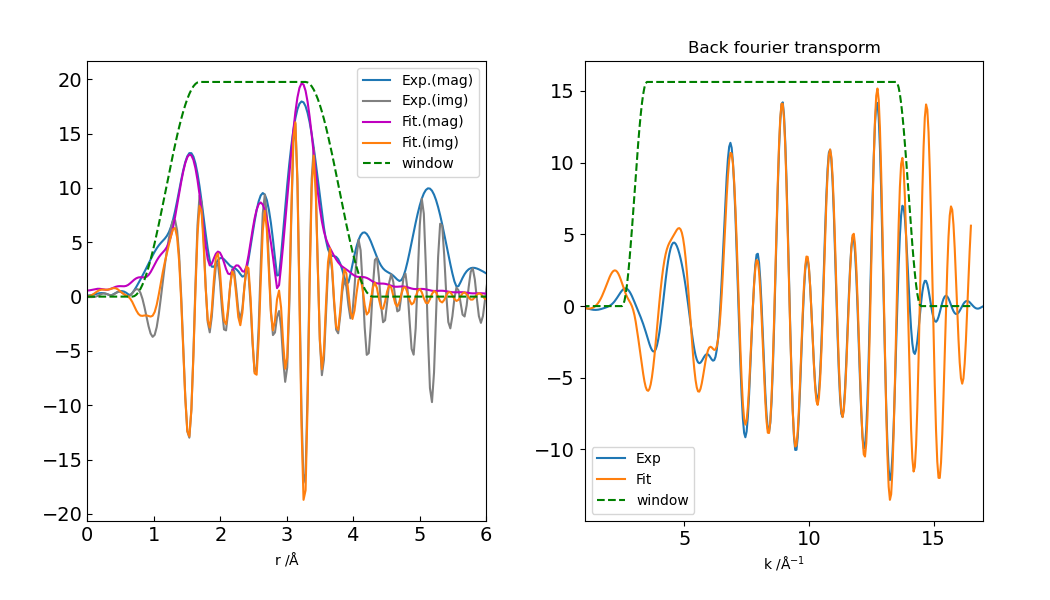

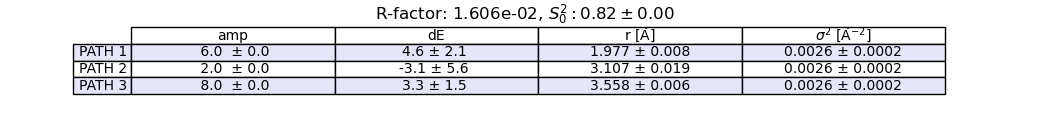

In [103]:
trans = feffit_transform(kmin=kmin_fit.value, kmax=kmax_fit.value, kw=n_kweight.value,
                         dk=deltak.value, window=wintype_r.value, rmin=rmin_fit.value, rmax=rmax_fit.value,dr=deltar.value)
dset  = feffit_dataset(data=dat, pathlist=List_feffpaths, transform=trans)

out = feffit(pars, dset)

scale=5

# print(feffit_report(out))

_parameters =[x for x in pars.__dict__.keys() if not (x in ['__params__', '__name__', '__exprsave__'])]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10.5, 6.0)
fig.tight_layout(pad=4)
scale= np.max(dset.data.chir_mag)*1.1
ax[0].plot(dset.data.r,dset.data.chir_mag,label='Exp.(mag)')
ax[0].plot(dset.data.r,dset.data.chir_im,color='grey',label='Exp.(img)')
ax[0].set_xlim([0.0,6.0])
ax[0].plot(dset.model.r,dset.model.chir_mag,color='m',label='Fit.(mag)')
ax[0].plot(dset.model.r,dset.model.chir_im,color='tab:orange',label='Fit.(img)')
ax[0].plot(dset.data.r,dset.data.rwin*scale,'--',color='green', label='window')
ax[0].set_xlabel('r /$\mathrm{\AA}$')
ax[0].tick_params(direction="in")
ax[0].tick_params(axis='both',labelsize=14)
ax[0].legend()

xftr(dset.data.r,dset.data.chir,rmin=rmin_fit.value,rmax=rmax_fit.value,group=dset.data,window=wintype_r.value)

# ax[1].plot(dset.data.k,dset.data.chi*dset.data.k**3)
ax[1].set_xlim([1,17.0])
ax[1].set_xlabel('k /$\mathrm{\AA}^{-1}$')
ax[1].plot(dset.data.q,dset.data.chiq,label='Exp')
ax[1].plot(dset.model.k,dset.model.chi*dset.model.k**n_kweight.value,label='Fit')
scale= np.max(dset.data.chiq)*1.1
ax[1].plot(dset.data.k,dset.data.kwin*scale,'--',color='green', label='window')
ax[1].tick_params(axis='both',labelsize=14)
ax[1].set_title('Back fourier transporm')
ax[1].legend()

    # print ('| {:^5.1f} +/- {:^5.1f}| {:^10s} | {:^10s} | {:^10s} | {:^10s} |'.format('path','amp', 'dE', 'r', '\u03C3^2')))
    
labels_clms = ['amp', 'dE', 'r [$\mathrm{\mathring A}$]', '$\sigma^2\ [\mathrm{\mathring A}^{-2}]$']
cell_text = []
labels_row = []
labelrow_colors= []
cellcolors=[]
_colors = ['lavender','white']
for i in range(n_paths.value):
    labels_row.append('PATH {:d}'.format(i+1))
    labelrow_colors.append(_colors[i%2])
    
    _path = path_widgets['path{:d}'.format(i+1)]
    
    _n = _path['amp'][1].value
    _amp = out.params[_n].value
    _stdr_amp = out.params[_n].stderr
    
    _n = _path['dE'][1].value
    _dE = out.params[_n].value
    _stdr_dE = out.params[_n].stderr
    
    _n = _path['dr'][1].value
    _r = List_feffpaths[i]._feffdat.reff+ out.params[_n].value
    _stdr_dr = out.params[_n].stderr
    
    _n = _path['ss'][1].value
    _ss = out.params[_n].value
    _stdr_ss = out.params[_n].stderr
    _out = [' {:^4.1f} \u00B1 {:^3.1f}'.format(_amp,_stdr_amp),  
            '{:^3.1f} \u00B1 {:^3.1f} '.format(_dE,_stdr_dE),
            '{:^2.3f} \u00B1 {:^2.3f}'.format(_r,_stdr_dr),
            '{:^.4f} \u00B1 {:^.4f}'.format(_ss,_stdr_ss)]
    _tcolors = [_colors[i%2]]*4
    
    cell_text.append(_out)
    cellcolors.append(_tcolors)

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 1.2)
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
    
t = ax.table(cellText=cell_text,
         rowLabels=labels_row,
        rowColours=labelrow_colors,
        colLabels=labels_clms,
        cellColours = cellcolors,
        cellLoc = 'center',
        loc='center')
t.set_fontsize(10)
fig.suptitle('R-factor: {:.3e}, $S_0^2: {:.2f} \pm {:.2f}$'.format(out.rfactor,out.params[name_s02.value].value,out.params[name_s02.value].stderr))
t

### Display the detailed results of the fitting (feffit_report)

In [102]:
print(feffit_report(out))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  7, 168
   n_independent      =  19.207
   chi_square         =  221.992082
   reduced chi_square =  18.1851530
   r-factor           =  0.01606103
   Akaike info crit   =  61.0070475
   Bayesian info crit =  67.6940897
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.200, 3.800
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['/Users/uemura_y/GoogleDrive/XAFS_Motokura/2021March_Motokura/RuO2/feff0001.dat', '/Users/uemura_y/GoogleDrive/XAFS_Motokura/2021March_Motokura/RuO2/feff0003.dat', '/Users/uemura_y/GoogleDrive/XAFS_Motokura/2021March_Motokura/RuO2/feff0007.dat']
   k-weight           = 3
   epsilon_k          = Array(mean=9.8992e-04, std=0.00220176)
   epsilon_r          = 0.24231194
   n_independent      = 19.207
 
[[Variables]]
   S02            =  0.82000000 (fixed)
   amp1           =  6.00000000 (fixed)
   amp2 

In [69]:
print ('============================== Results in a table ==============================')
print ('| {:^15s} | {:^10s} | {:^10s} | {:^12s}  | {:^15s} |'.format('','amp', 'dE', 'r', '\u03C3^2'))
for i in range(n_paths.value):
    _path = path_widgets['path{:d}'.format(i+1)]
    
    _n = _path['amp'][1].value
    _amp = out.params[_n].value
    _stdr_amp = out.params[_n].stderr
    
    _n = _path['dE'][1].value
    _dE = out.params[_n].value
    _stdr_dE = out.params[_n].stderr
    
    _n = _path['dr'][1].value
    _r = List_feffpaths[i]._feffdat.reff+ out.params[_n].value
    _stdr_dr = out.params[_n].stderr
    
    _n = _path['ss'][1].value
    _ss = out.params[_n].value
    _stdr_ss = out.params[_n].stderr
    print ('|  {:>15s}'.format('PATH '+str(i+1))+'| {:^4.1f} \u00B1 {:^3.1f} | {:^3.1f} \u00B1 {:^3.1f} | {:^2.3f} \u00B1 {:^2.3f} | {:^.4f} \u00B1 {:^.4f} |'.\
           format(_amp,_stdr_amp,_dE,_stdr_dE,_r,_stdr_dr,_ss,_stdr_ss) )

============================== Results in a table ==============================
|                 |    amp     |     dE     |      r        |       σ^2       |
|           PATH 1| 6.0  ± 0.0 | 4.6 ± 2.1 | 1.977 ± 0.008 | 0.0025 ± 0.0000 |
|           PATH 2| 2.0  ± 0.0 | -2.8 ± 5.4 | 3.109 ± 0.017 | 0.0025 ± 0.0000 |
|           PATH 3| 8.0  ± 0.0 | 3.2 ± 1.5 | 3.558 ± 0.006 | 0.0025 ± 0.0000 |


In [86]:
out.params['S02'].value

0.809253051072608